In [2]:
import pandas as pd
import numpy as np
from surprise import SVD, accuracy, SVDpp
from surprise import Dataset, Reader
import matplotlib.pyplot as plt

In [4]:
train_data = pd.read_csv('train.csv')
valid_data = pd.read_csv('valid.csv')
test_data = pd.read_csv('test.csv')

In [7]:
print(len(train_data), len(valid_data), len(test_data))

905894 113236 113237


In [8]:
train_data.head()

,user,item,rating
0,113920,108234,0
1,40482,15627,4
2,59345,17898,3
3,73568,143053,2
4,5015,20171,5


In [28]:
# let's only use 1/10 of the train data
# train_data = train_data.sample(frac=0.1, random_state=42)

In [5]:
reader = Reader(rating_scale=(0, 5))
train_dataset = Dataset.load_from_df(train_data[['user', 'item', 'rating']], reader)
trainset = train_dataset.build_full_trainset()

In [10]:
valid_dataset = Dataset.load_from_df(valid_data[['user', 'item', 'rating']], reader)
validset = valid_dataset.build_full_trainset().build_testset()

In [6]:
# calculate the mean and std of the validation set
mean = train_data['rating'].mean()
var = train_data['rating'].var()
print(mean, var)
mean = valid_data['rating'].mean()
var = valid_data['rating'].var()
print(mean, var)


4.41098848209614 1.6014121493971378
4.413790667278957 1.5900863204307607
4.408461898496075 1.5946025275430167


In [12]:
users_in_train = train_data['user'].unique()
items_in_train = train_data['item'].unique()
users_in_valid = valid_data['user'].unique()
items_in_valid = valid_data['item'].unique()
items_in_test = test_data['item'].unique()


In [13]:
print("users in train: ", len(users_in_train))
print("users in valid: ", len(users_in_valid))
print("users not seen in train: ", len(set(users_in_valid) - set(users_in_train)))


users in train:  192306
users in valid:  41194
users not seen in train:  17445


In [14]:
print("items in train: ", len(items_in_train))
print("items in valid: ", len(items_in_valid))
print("items not seen in train: ", len(set(items_in_valid) - set(items_in_train)))

items in train:  211274
items in valid:  63487
items not seen in train:  10761


In [6]:
# merge train and valid frame
cv_data = pd.concat([train_data, valid_data], ignore_index=True)
cv_dataset = Dataset.load_from_df(cv_data[['user', 'item', 'rating']], reader)

In [16]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors': [1, 2, 5, 10], 'lr_all': [2e-3, 5e-3, 0.01]}
model_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
model_gs.fit(cv_dataset)
print(model_gs.best_params)
print(model_gs.best_score)


{'rmse': {'n_factors': 1, 'lr_all': 0.005}}
{'rmse': 1.2146720718719497}


In [114]:
param_grid = {'reg_bu': [0.005, 0.01, 0.02], 'reg_bi': [0.2, 0.4, 1], 'reg_all': [0.2], 'n_factors': [1], 'lr_all': [0.005]}
model_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
model_gs.fit(cv_dataset)
print(model_gs.best_params)
print(model_gs.best_score)

{'rmse': {'reg_bu': 0.005, 'reg_bi': 0.4, 'reg_all': 0.2, 'n_factors': 1, 'lr_all': 0.005}}
{'rmse': 1.2150348501852548}


In [118]:
param_grid = {'n_factors': [1], 'lr_all': [0.005], 'reg_bu': [0.005, 0.01], 'reg_bi': [0.4, 0.5], 'reg_pu': [0.4, 0.5], 'reg_qi': [0.005, 0.1, 0.2]}
model_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
model_gs.fit(cv_dataset)
print(model_gs.best_params)
print(model_gs.best_score)


{'rmse': {'n_factors': 1, 'lr_all': 0.005, 'reg_bu': 0.005, 'reg_bi': 0.5, 'reg_pu': 0.5, 'reg_qi': 0.1}}
{'rmse': 1.2148617303712848}


In [7]:
# train the model with the best params
model = SVD(n_factors=1, reg_bu=0.005, reg_bi=0.5, reg_pu=0.5, reg_qi=0.1, lr_all=0.005)
model.fit(cv_dataset.build_full_trainset())

In [9]:

testset = Dataset.load_from_df(test_data[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

In [10]:
predictions = model.test(testset)
mse = accuracy.mse(predictions=predictions)

MSE: 1.4535


In [13]:
predictions[:20]

[Prediction(uid=577, iid=24831, r_ui=4.0, est=4.267370432060136, details={'was_impossible': False}),
 Prediction(uid=577, iid=30750, r_ui=4.0, est=4.233846583428183, details={'was_impossible': False}),
 Prediction(uid=577, iid=20947, r_ui=4.0, est=4.267370432060136, details={'was_impossible': False}),
 Prediction(uid=9213, iid=77881, r_ui=4.0, est=4.105716912070218, details={'was_impossible': False}),
 Prediction(uid=9213, iid=45515, r_ui=5.0, est=4.144070979558454, details={'was_impossible': False}),
 Prediction(uid=9213, iid=20364, r_ui=4.0, est=3.997291326808147, details={'was_impossible': False}),
 Prediction(uid=9213, iid=5715, r_ui=4.0, est=3.5686409656225972, details={'was_impossible': False}),
 Prediction(uid=9213, iid=59923, r_ui=4.0, est=4.016469913652654, details={'was_impossible': False}),
 Prediction(uid=9213, iid=9254, r_ui=4.0, est=4.035542767258308, details={'was_impossible': False}),
 Prediction(uid=9213, iid=41232, r_ui=2.0, est=4.120965171025998, details={'was_imposs

(array([ 6033.,     0.,  1287.,     0.,  1390.,     0.,  4071.,     0.,
        18755., 81700.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

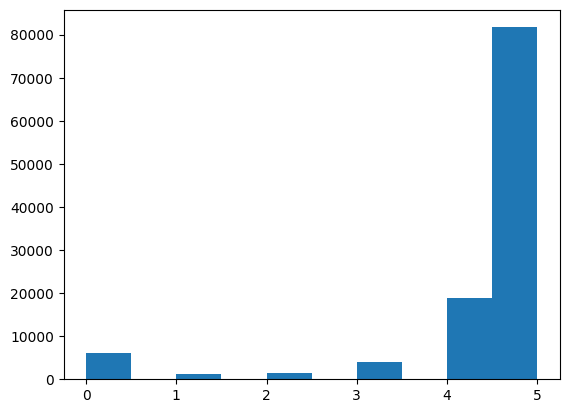

In [11]:
plt.hist(valid_data['rating'], bins=10, range=(0, 5))

(array([ 48801.,      0.,  10227.,      0.,  11272.,      0.,  32518.,
             0., 149817., 653259.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

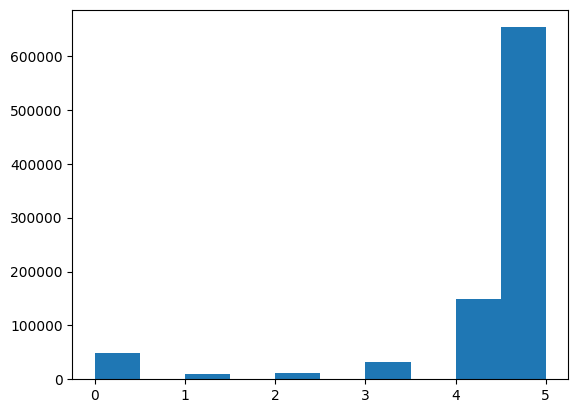

In [13]:
plt.hist(train_data['rating'], bins=10, range=(0,5))

In [14]:
# errors = [abs(p.r_ui - p.est) for p in predictions]
errors = [p.est for p in predictions]
# draw a histogram of the errors
plt.hist(errors, bins=25, range=(0, 5))

NameError: name 'predictions' is not defined

(array([ 6013.,     0.,  1304.,     0.,  1461.,     0.,  4266.,     0.,
        18788., 81405.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

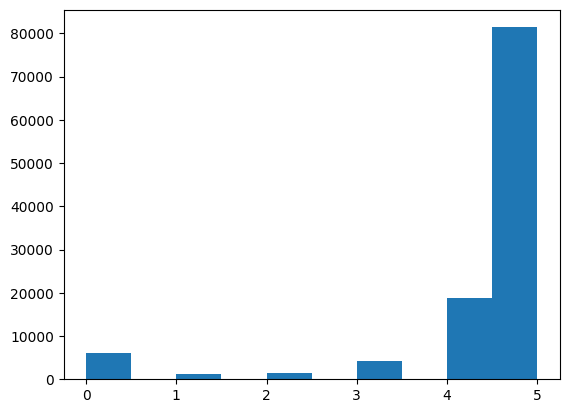

In [25]:
labels = [p.r_ui for p in predictions]
plt.hist(labels, bins=10, range=(0, 5))